imports

In [1]:
from __future__ import print_function, division
from builtins import range

import os
import sys,re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalMaxPool1D, Bidirectional, Conv1D
from tensorflow.keras.layers import LSTM, MaxPooling1D, Embedding, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.metrics import roc_auc_score

some configuration

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
EPOCHS = 10

load in pre-trained word vectors

In [3]:
word2vec = {}
with open(os.path.join('/home/hassan/Documents/machine_learning_examples/nlp_class3/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec


In [4]:
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


prepare text samples and their labels

In [8]:
sentences = np.empty(0,dtype='object')
targets = np.zeros((0,7))
labels = { "ArtOrDet":0, "Nn":1, "Vt":2, "Prep":3, "Vform":4, "Wform":5, "SVA":6}
i=0
f=open('/home/hassan/Documents/machine_learning_examples/nlp_class3/toxic/conll14st-preprocessed.m2')
line = f.readline()
while line:
    line = line.strip()
    if line:
        # print(line)
        if re.search("^S",line):
            a=np.empty(1,dtype='object')
            a[0]=line[2:]
            sentences=np.concatenate([sentences,a])
            b=np.zeros((1,7))
            targets=np.concatenate([targets,b])
            i=i+1
        elif re.search("^A",line):
            # print("found annotation")
            for key in labels:
                # print(labels.get(key))
                if re.search(key,line):
                    # print(labels.get(key))
                    targets[i-1,labels.get(key)]=1
                    break
    line=f.readline()



In [30]:
print(targets[3])
print(targets[5])
print(targets.shape)
print("found line", i)

[0. 1. 0. 0. 1. 0. 1.]
[0. 1. 0. 0. 0. 0. 0.]
(57151, 7)
found line 28601


convert the sentences (strings) into integers

In [10]:
print('Tokenization...')
tokenizer = Tokenizer( num_words=MAX_VOCAB_SIZE, filters='!"#$%&*+-/<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

word2idx = tokenizer.word_index

Tokenization...


In [12]:
print("sequence[0]: ", sequences[0])

print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
# s = sorted(len(s) for s in sequences)
# print("median sequence length:", s[len(s) // 2])
#
# print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

print('Found %s unique tokens.' % len(word2idx))
# print(next(iter(word2idx)))

sequence[0]:  [1087, 9, 7713, 226]
max sequence length: 130
min sequence length: 0
Found 28601 unique tokens.


pad sequences so that we get a N x T matrix

In [13]:
print('Pad sequences...')
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


Pad sequences...


In [15]:
print("data[0]", data[0])
print('Shape of data tensor:', data.shape)

data[0] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 1087    9
 7713  226]
Shape of data tensor: (57151, 100)


prepare embedding matrix

In [16]:
print('Filling pre-trained embeddings...')
print("len word2idx", len(word2idx))
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...
len word2idx 28601


In [18]:
print("embedding_matrix shape:", embedding_matrix.shape)
print(word2idx.get("creating"))
print("embedding_matrix[1113]", embedding_matrix[1113])

embedding_matrix shape: (20000, 50)
1087
embedding_matrix[1113] [ 0.49699    -0.38646999  0.53082001 -0.091778   -0.11738    -0.04102
 -0.50743997 -0.06322    -0.42208001  0.074554   -0.19433001 -0.036245
 -0.58236998  0.38620001  0.14978001  0.1804     -0.099115   -0.59814
  0.28531    -0.11149     0.13049001 -0.38992     0.030325   -0.42905
 -0.22137    -1.41120005  0.094014   -0.34946999  0.010534    0.070527
  2.24099994  0.45576999 -1.39999998 -0.55597001 -0.29089999 -0.34981
  0.16367     0.50111997 -0.32163    -0.64955002 -0.53886998 -0.30575001
 -0.27078    -0.38091001 -0.37178999  0.13150001 -0.44901001  0.051905
  0.31749001  0.11395   ]


load pre-trained word embeddings into an Embedding layer <br/>
note that we set trainable = False so as to keep the embeddings fixed

In [23]:
print('Building Embedding layer ...')
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

Building Embedding layer ...


Building model...

In [24]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='sigmoid')(x)

model = Model(input_, output)

In [25]:
model.compile(
   loss='binary_crossentropy',
   optimizer='adam',
   metrics=['accuracy']
)

In [26]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
715/715 [==============================] - 37s 52ms/step - loss: 0.1904 - accuracy: 0.7890 - val_loss: 0.1277 - val_accuracy: 0.8906
Epoch 2/10
715/715 [==============================] - 35s 49ms/step - loss: 0.1808 - accuracy: 0.7932 - val_loss: 0.1268 - val_accuracy: 0.7599
Epoch 3/10
715/715 [==============================] - 26s 37ms/step - loss: 0.1783 - accuracy: 0.7396 - val_loss: 0.1249 - val_accuracy: 0.8714
Epoch 4/10
715/715 [==============================] - 25s 35ms/step - loss: 0.1754 - accuracy: 0.7168 - val_loss: 0.1312 - val_accuracy: 0.4797
Epoch 5/10
715/715 [==============================] - 27s 38ms/step - loss: 0.1711 - accuracy: 0.6633 - val_loss: 0.1252 - val_accuracy: 0.7424
Epoch 6/10
715/715 [==============================] - 30s 42ms/step - loss: 0.1651 - accuracy: 0.6282 - val_loss: 0.1280 - val_accuracy: 0.4830
Epoch 7/10
715/715 [==============================] - 28s 39ms/step - loss: 0.1584 - accuracy: 0.5992 - val_loss: 0.13

plot some data

In [27]:
%matplotlib inline

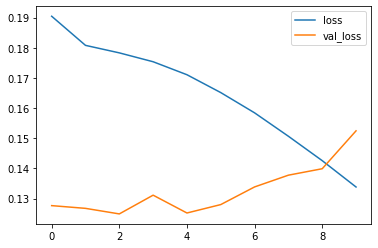

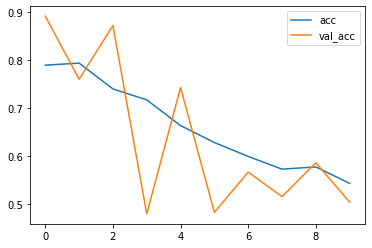

In [28]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [29]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.8902541397342842
